In [1]:
import os
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import math
import json

from matplotlib.ticker import MultipleLocator

from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
from reportlab.pdfbase.ttfonts import TTFont
from reportlab.pdfbase import pdfmetrics
from reportlab.lib.utils import ImageReader

from stream_analysis.env_ import Env_
from stream_analysis.chat import Chat
from stream_analysis.summary import Summary
from stream_analysis.utils import minutes_to_hhmm

%matplotlib inline

c:\Users\asus\Documents\Test\test\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\asus\Documents\Test\test\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model train

In [2]:
def get_word_freq(array):
    text_vectorizer = CountVectorizer(stop_words='english', encoding='utf8')
    X = text_vectorizer.fit_transform(array)
    word_freq = pd.DataFrame(
        X.toarray(), columns=text_vectorizer.get_feature_names_out())
    word_freq = word_freq.sum().sort_values(ascending=False)
    return word_freq


def draw_markdown_to_pdf(canvas, text, cursor, margin, width, height, font_name):
    # 轉換 Markdown 到純文本
    paragraphs = text.split('\n')

    canvas.setFont(font_name, 8)
    for paragraph in paragraphs:
        lines = paragraph.split('\n')
        for line in lines:
            # 計算每一行文本的寬度並進行多行處理
            if cursor < 50:  # 確保不超出頁面底部
                canvas.showPage()
                cursor = height - 50
            text_width = canvas.stringWidth(line, font_name, 12)
            if text_width > width:
                # 如果行寬超出可用寬度，進行換行處理
                words = line.split(' ')
                current_line = ""
                for word in words:
                    if canvas.stringWidth(current_line + word, font_name, 12) > width:
                        canvas.drawString(margin, cursor, current_line.strip())
                        cursor -= 15
                        current_line = word + ' '
                    else:
                        current_line += word + ' '
                if current_line:
                    canvas.drawString(margin, cursor, current_line.strip())
                    cursor -= 15
            else:
                canvas.drawString(margin, cursor, line.strip())
                cursor -= 15
    return cursor

In [3]:
env_ = Env_(video_live_url='https://www.youtube.com/live/xSHw_eNgEIM?si=XWo6DM6mhtjKW2BS')

with open(env_.video_data_path, 'w', encoding='utf8') as f:
    json.dump(env_.video_data, f, indent=2, ensure_ascii=False)

In [4]:
chat = Chat(env_)
df = chat.get()
chat.df_per_min.to_csv(env_.chat_per_min_csv_path, index=False)

In [5]:
chat.hightlight_urls

['https://youtube.com/watch?v=xSHw_eNgEIM&t=1m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=23m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=33m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=44m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=55m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=73m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=83m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=98m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=105m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=113m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=132m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=136m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=142m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=152m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=168m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=180m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=186m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=207m',
 'https://youtube.com/watch?v=xSHw_eNgEIM&t=211m',
 'https://youtube.com/watch?v=xSHw_eNgEI

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22523 entries, 0 to 22522
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   author_id                   22523 non-null  object 
 1   author_name                 22523 non-null  object 
 2   author_title                22523 non-null  object 
 3   author_membership_duration  22523 non-null  int64  
 4   author_badge                22523 non-null  object 
 5   author_image                22523 non-null  object 
 6   message                     22523 non-null  object 
 7   message_without_emotes      22523 non-null  object 
 8   cleaned_message             22523 non-null  object 
 9   message_type                22523 non-null  object 
 10  money                       22523 non-null  float64
 11  positive                    22523 non-null  float64
 12  neutral                     22523 non-null  float64
 13  negative                    225

In [23]:
df.head()

author_id                       author_name author_title  \
0   UCvqCq8lbpiZ9Ueks784u4oQ                              Rave       member   
1   UCka95ZsvD7P4tT7a2A9r-uA                     Crazesergeant       member   
2   UCr4zekP8VkAomxp3H0utOew                    KuriousEmbrace                
3   UChpLoCOX1bhtDuSrKRsInPQ                       Dongerbread       member   
4   UCRlKp8Z8dHpfsYB-fbsIAEg                        Ran Bindoy       member   
5   UCm_35i5puywsoj-fv2k_LlQ                               Ash                
6   UCD7HLbClvabyPWqaI5ojdeA   Yumirix - KFP's Deadbeat Lizard       member   
7   UCka95ZsvD7P4tT7a2A9r-uA                     Crazesergeant       member   
8   UCpwgHy05Dc1RGz_avoMHtzQ                          Eupator5       member   
9   UCFEDvaMi0ImutQd9F4Bl-Fg                     Antbruni18k 💀       member   
10  UCvNrttfsrya5EeHnHQDJaRQ                         BeeDeeKay       member   
11  UCYvWNs145vjUyUXlry_vjbQ                         Charlzboi                
12  UCwfKn3hTtJhXGUi5oqSmzgQ                        CravyGravy                
13  UCvNrttfsrya5EeHnHQDJaRQ                         BeeDeeKay       member   
14  UCvqCq8lbpiZ9Ueks784u4oQ                              Rave       member   
15  UCFEDvaMi0ImutQd9F4Bl-Fg                     Antbruni18k 💀       member   
16  UCmgsYaX8xfXz1MJ4AqKm8AA                   SilverScizor753       member   
17  UCsk7r6lrSEYBgQT20pBH4Qg                         Winterage                
18  UCx9Nx8tkpPMA7TgmN0ptyzw                          Fumei KY       member   
19  UCpwgHy05Dc1RGz_avoMHtzQ                          Eupator5       member   
20  UCb3fox7oWETsbDJMV_FPKig                            Aarven       member   
21  UC7F53t_24_uo7_XIb8otAyA                              YH J                
22  UCcXfn1di_amnYcdSTkvqGGQ                           Owlette       member   
23  UC6TGisS9qkdkbGnXygTG6sA                     Ghost Sapling       member   
24  UCQnCVeW5n0dpAJYNJZcoRRQ                           TaihouZ                
25  UC3Ol2DRaqE16GlHmzfQckuQ  InuHoshi💀🐔 - HoloEN lovin' doggo       member   
26  UCbHwxDR2erLmaQtIjpaFHyg                       Light Seiba                
27  UC1cNChWk9eQrmWO08ZYsWDw                             Lopen       member   
28  UCLTIF17d0CbLFFn0KEmjhhA                             Sarge                
29  UCRlKp8Z8dHpfsYB-fbsIAEg                        Ran Bindoy       member   

    author_membership_duration  \
0                         1095   
1                          180   
2                            0   
3                         1095   
4                          365   
5                            0   
6                         1095   
7                          180   
8                          730   
9                          365   
10                         180   
11                           0   
12                           0   
13                         180   
14                        1095   
15                         365   
16                         730   
17                           0   
18                        1095   
19                         730   
20                         180   
21                           0   
22                         365   
23                         365   
24                           0   
25                         365   
26                           0   
27                        1095   
28                           0   
29                         365   

                                         author_badge  \
0   https://yt3.ggpht.com/vPMJm64_X3uH9dgKzmZ_udFs...   
1   https://yt3.ggpht.com/5soInI8jLqQrqNXv8r3Ewtfu...   
2                                                       
3   https://yt3.ggpht.com/vPMJm64_X3uH9dgKzmZ_udFs...   
4   https://yt3.ggpht.com/F0YU4PUesWXUyOENvw51yhHC...   
5                                                       
6   https://yt3.ggpht.com/vPMJm64_X3uH9dgKzmZ_udFs...   
7   https://yt3.ggpht.com/5soInI8jLqQrqNXv8r3Ewtfu...   
8

In [8]:
df['message'].nunique()

14524

In [9]:
df_cleaned = df[df['cleaned_message'].str.len() > 0][['author_id', 'message', 'cleaned_message']]
df_cleaned

author_id                                message  \
0      UCvqCq8lbpiZ9Ueks784u4oQ  Time to bring peace to these streets    
1      UCka95ZsvD7P4tT7a2A9r-uA                         Howdy Eupator5   
2      UCr4zekP8VkAomxp3H0utOew      Good morning day and evening chat   
3      UChpLoCOX1bhtDuSrKRsInPQ                         One last ride    
5      UCm_35i5puywsoj-fv2k_LlQ                              mori doko   
...                         ...                                    ...   
22518  UCwZsQPDCpgflaFHZSuq5-0Q                                 Peace    
22519  UCzuRdHfr3kwaYPJvjyfBU5A                            :_RipP:eace   
22520  UCKkILxld9WRWfpYpaP5V3bQ            take care everyone :skull:7   
22521  UCwDJNKVHfcFiSPoOl1GNFkA                            :_RipP:EACE   
22522  UCD6enu5eVEwuhj0G9wJBrsg                            Take care!!   

                            cleaned_message  
0      Time to bring peace to these streets  
1                            Howdy Eupator5  
2              morning day and evening chat  
3                             One last ride  
5                                 mori doko  
...                                     ...  
22518                                 Peace  
22519                                 Peace  
22520                    take care everyone  
22521                                 PEACE  
22522                             Take care  

[14577 rows x 3 columns]

In [10]:
from stream_analysis.analyzer import get_sentiment


msg = df_cleaned['message'].iloc[15]
display(msg)
get_sentiment(msg)

'Here we go.'

(0.6650511622428894, 0.23557204008102417, 0.09937675297260284, 'neutral')

In [11]:
df['message_without_emotes'].nunique()

13612

In [12]:
df['cleaned_message'].nunique()

12237

In [13]:
chat.df_per_min.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356 entries, 0 to 355
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   time_in_minutes          356 non-null    int64  
 1   active_users             356 non-null    int64  
 2   membership_duration_avg  356 non-null    float64
 3   money_sum                356 non-null    float64
 4   messages                 356 non-null    int64  
 5   message_without_emotes   356 non-null    int64  
 6   cleaned_messages         356 non-null    int64  
 7   member_messages          356 non-null    int64  
 8   messages_moving_avg      356 non-null    float64
 9   is_above_average         356 non-null    bool   
dtypes: bool(1), float64(3), int64(6)
memory usage: 25.5 KB


In [14]:
chat.df_per_min.head()

time_in_minutes  active_users  membership_duration_avg  money_sum  \
0                0            27               403.333333   0.000000   
1                1            63               361.666667   0.000000   
2                2            48               370.769231   5.000000   
3                3            31               372.804878   0.000000   
4                4            53               338.642857   6.926291   

   messages  message_without_emotes  cleaned_messages  member_messages  \
0        33                      21                19               22   
1        81                      34                32               57   
2        65                      38                36               43   
3        41                      14                14               34   
4        70                      34                30               49   

   messages_moving_avg  is_above_average  
0            63.238764             False  
1            63.238764              True  
2            63.238764              True  
3            63.238764             False  
4            63.238764              True

In [15]:
chat.df_per_min.drop(columns=['time_in_minutes', 'messages_moving_avg']).describe()

active_users  membership_duration_avg   money_sum    messages  \
count    356.000000               356.000000  356.000000  356.000000   
mean      49.626404               410.825861    0.932982   63.238764   
std       32.341719                84.244431    7.406910   45.939970   
min       11.000000                70.000000    0.000000   12.000000   
25%       28.000000               358.559243    0.000000   34.000000   
50%       40.000000               412.829787    0.000000   47.000000   
75%       60.000000               462.265957    0.000000   77.250000   
max      190.000000               659.000000  133.126712  290.000000   

       message_without_emotes  cleaned_messages  member_messages  
count              356.000000        356.000000       356.000000  
mean                48.556180         40.946629        39.744382  
std                 32.625915         25.565491        29.388881  
min                 11.000000          8.000000         3.000000  
25%                 27.750000         24.750000        21.000000  
50%                 38.000000         33.000000        31.000000  
75%                 58.000000         51.000000        48.000000  
max                211.000000        211.000000       170.000000

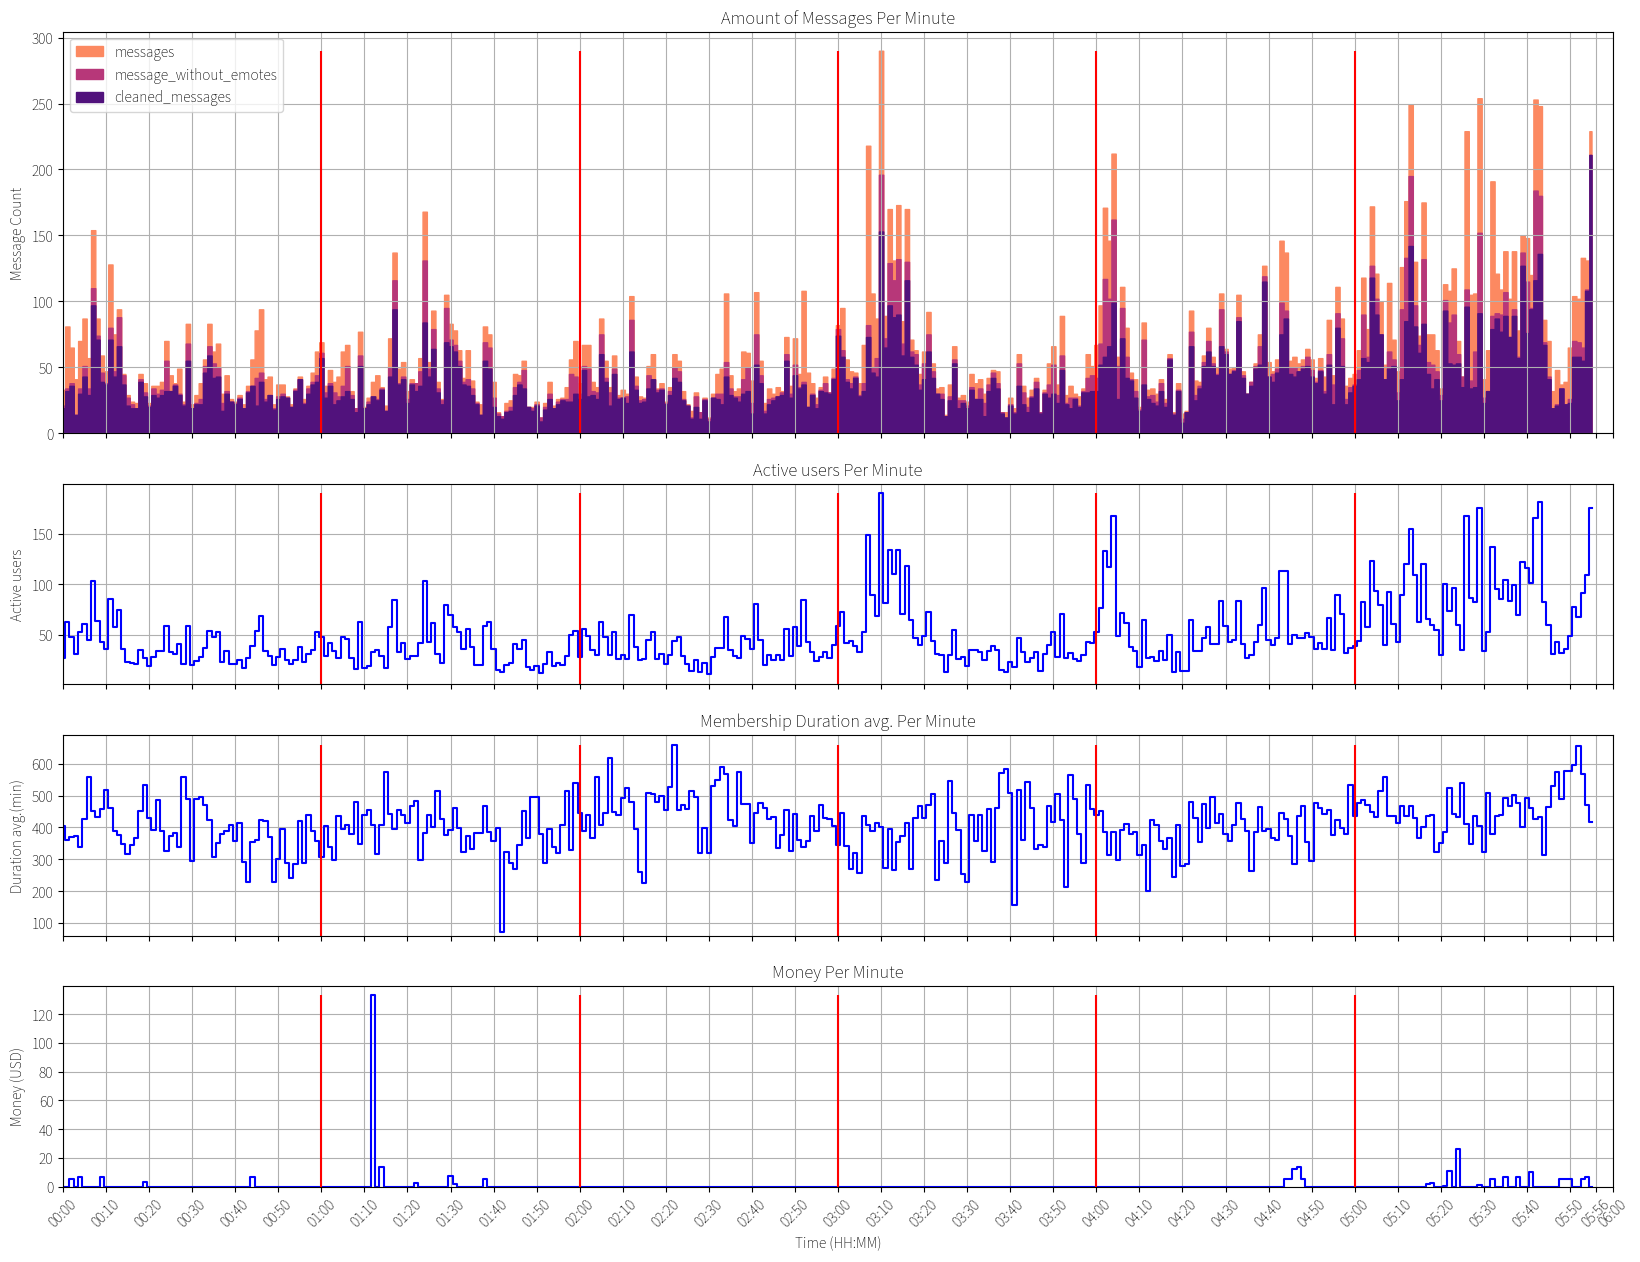

In [16]:
from stream_analysis.charts import ActivityPerMin

activity_per_min = ActivityPerMin(chat, env_)

In [17]:
chat.df_peaks

time_in_minutes  active_users  membership_duration_avg  money_sum  \
7                  7           103               452.305195   0.000000   
84                84           103               382.708333   0.000000   
187              187           149               409.059633   0.000000   
190              190           190               400.224138   0.000000   
192              192           134               394.264706   0.000000   
194              194           134               355.057803   0.000000   
196              196           118               413.411765   0.000000   
242              242           133               385.730994   0.000000   
244              244           167               385.707547   0.000000   
304              304           123               449.244186   0.000000   
312              312           120               436.619318   0.000000   
313              313           155               466.044177   0.000000   
316              316           120               401.193182   0.000000   
326              326           167               410.786026   0.000000   
329              329           175               403.602362   0.897897   
332              332           137               378.717277   5.000000   
342              342           165               426.600791   0.000000   
343              343           181               433.991935   0.000000   
355              355           175               416.331878   0.000000   

     messages  message_without_emotes  cleaned_messages  member_messages  \
7         154                     110                97              111   
84        168                     131                84              103   
187       218                      82                73              132   
190       290                     196               153              170   
192       170                     129                97               96   
194       173                     132                90               89   
196       170                     130               116              103   
242       171                     117                58               97   
244       212                     162                99              126   
304       172                     127               118              120   
312       176                     133                85              106   
313       249                     195               142              161   
316       175                     132                83               97   
326       229                     109                96              145   
329       254                     152                91              157   
332       191                      89                79              122   
342       253                     184               116              162   
343       248                     180               136              160   
355       229                     211               211              148   

     messages_moving_avg  is_above_average  
7              63.238764              True  
84             66.900000              True  
187            72.900000              True  
190           105.000000              True  
192           115.800000              True  
194           136.900000              True  
196           151.900000              True  
242            60.300000              True  
244            89.600000              True  
304            79.700000              True  
312           105.800000              True  
313           122.800000              True  
316           121.400000              True  
326            93.500000              True  
329           118.700000              True  
332           122.700000              True  
342           135.700000              True  
343           148.400000              True  
355            92.000000              True

In [18]:
chat.activity_ranges

[(np.int64(1), np.int64(13)),
 (np.int64(23), np.int64(29)),
 (np.int64(33), np.int64(36)),
 (np.int64(44), np.int64(46)),
 (np.int64(55), np.int64(69)),
 (np.int64(73), np.int64(79)),
 (np.int64(83), np.int64(91)),
 (np.int64(98), np.int64(99)),
 (np.int64(105), np.int64(107)),
 (np.int64(113), np.int64(128)),
 (np.int64(132), np.int64(132)),
 (np.int64(136), np.int64(137)),
 (np.int64(142), np.int64(143)),
 (np.int64(152), np.int64(161)),
 (np.int64(168), np.int64(172)),
 (np.int64(180), np.int64(182)),
 (np.int64(186), np.int64(196)),
 (np.int64(207), np.int64(207)),
 (np.int64(211), np.int64(217)),
 (np.int64(222), np.int64(232)),
 (np.int64(238), np.int64(246)),
 (np.int64(257), np.int64(257)),
 (np.int64(262), np.int64(273)),
 (np.int64(278), np.int64(279)),
 (np.int64(283), np.int64(284)),
 (np.int64(294), np.int64(297)),
 (np.int64(301), np.int64(316)),
 (np.int64(323), np.int64(343)),
 (np.int64(351), np.int64(355))]

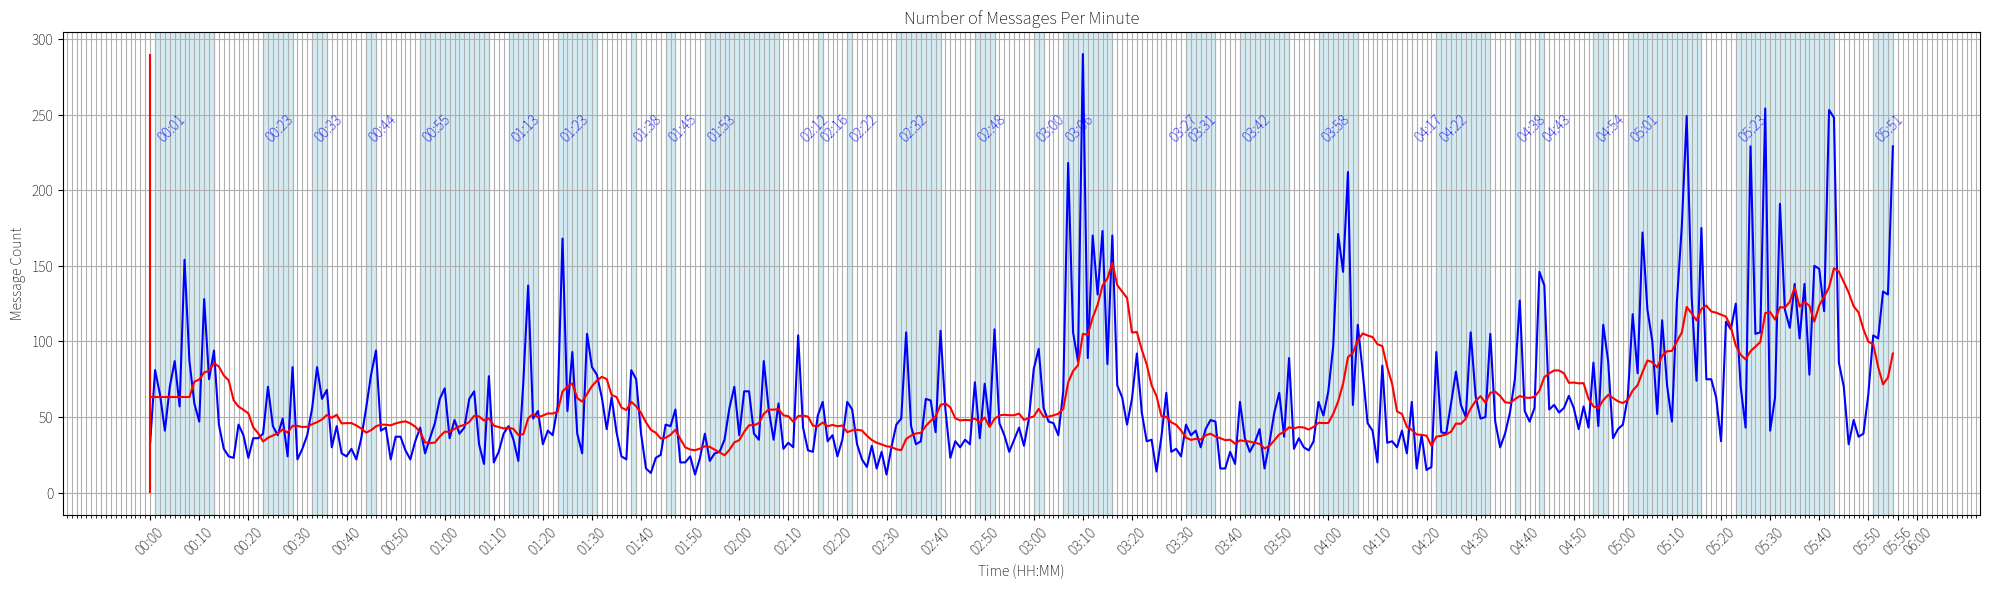

In [19]:
plt.figure(figsize=(20, 6))

plt.plot(chat.df_per_min['time_in_minutes'], chat.df_per_min['messages'], label='Total Messages', color='blue')

plt.plot(chat.df_per_min['time_in_minutes'], chat.df_per_min['messages_moving_avg'], label="Moving Average", color='red')

for start, end in chat.activity_ranges:
    plt.axvspan(start, end, color='lightblue', alpha=0.5)
    plt.text(start, chat.df_per_min['messages'].max() * 0.8, minutes_to_hhmm(start), color='blue', fontsize=10, rotation=45)

plt.vlines(0, ymin=0, ymax=chat.df_peaks['messages'].max(), colors='red')

plt.xticks(ticks=env_.time_labels[1], labels=env_.time_labels[0], rotation=45)
plt.gca().xaxis.set_minor_locator(MultipleLocator(1))
plt.xlabel('Time (HH:MM)')
plt.ylabel('Message Count')
plt.title('Number of Messages Per Minute')

plt.grid(True, which='both')
plt.tight_layout()
plt.savefig(env_.chat_timeline_path)
plt.show()

In [20]:
# from stream_analysis.summary import Summary

# df_filtered = df[df['cleaned_message'].str.len() > 0]

# summary = Summary(env_, '\n'.join(df_filtered[['message']].to_numpy().flatten())).getContent()
# summary

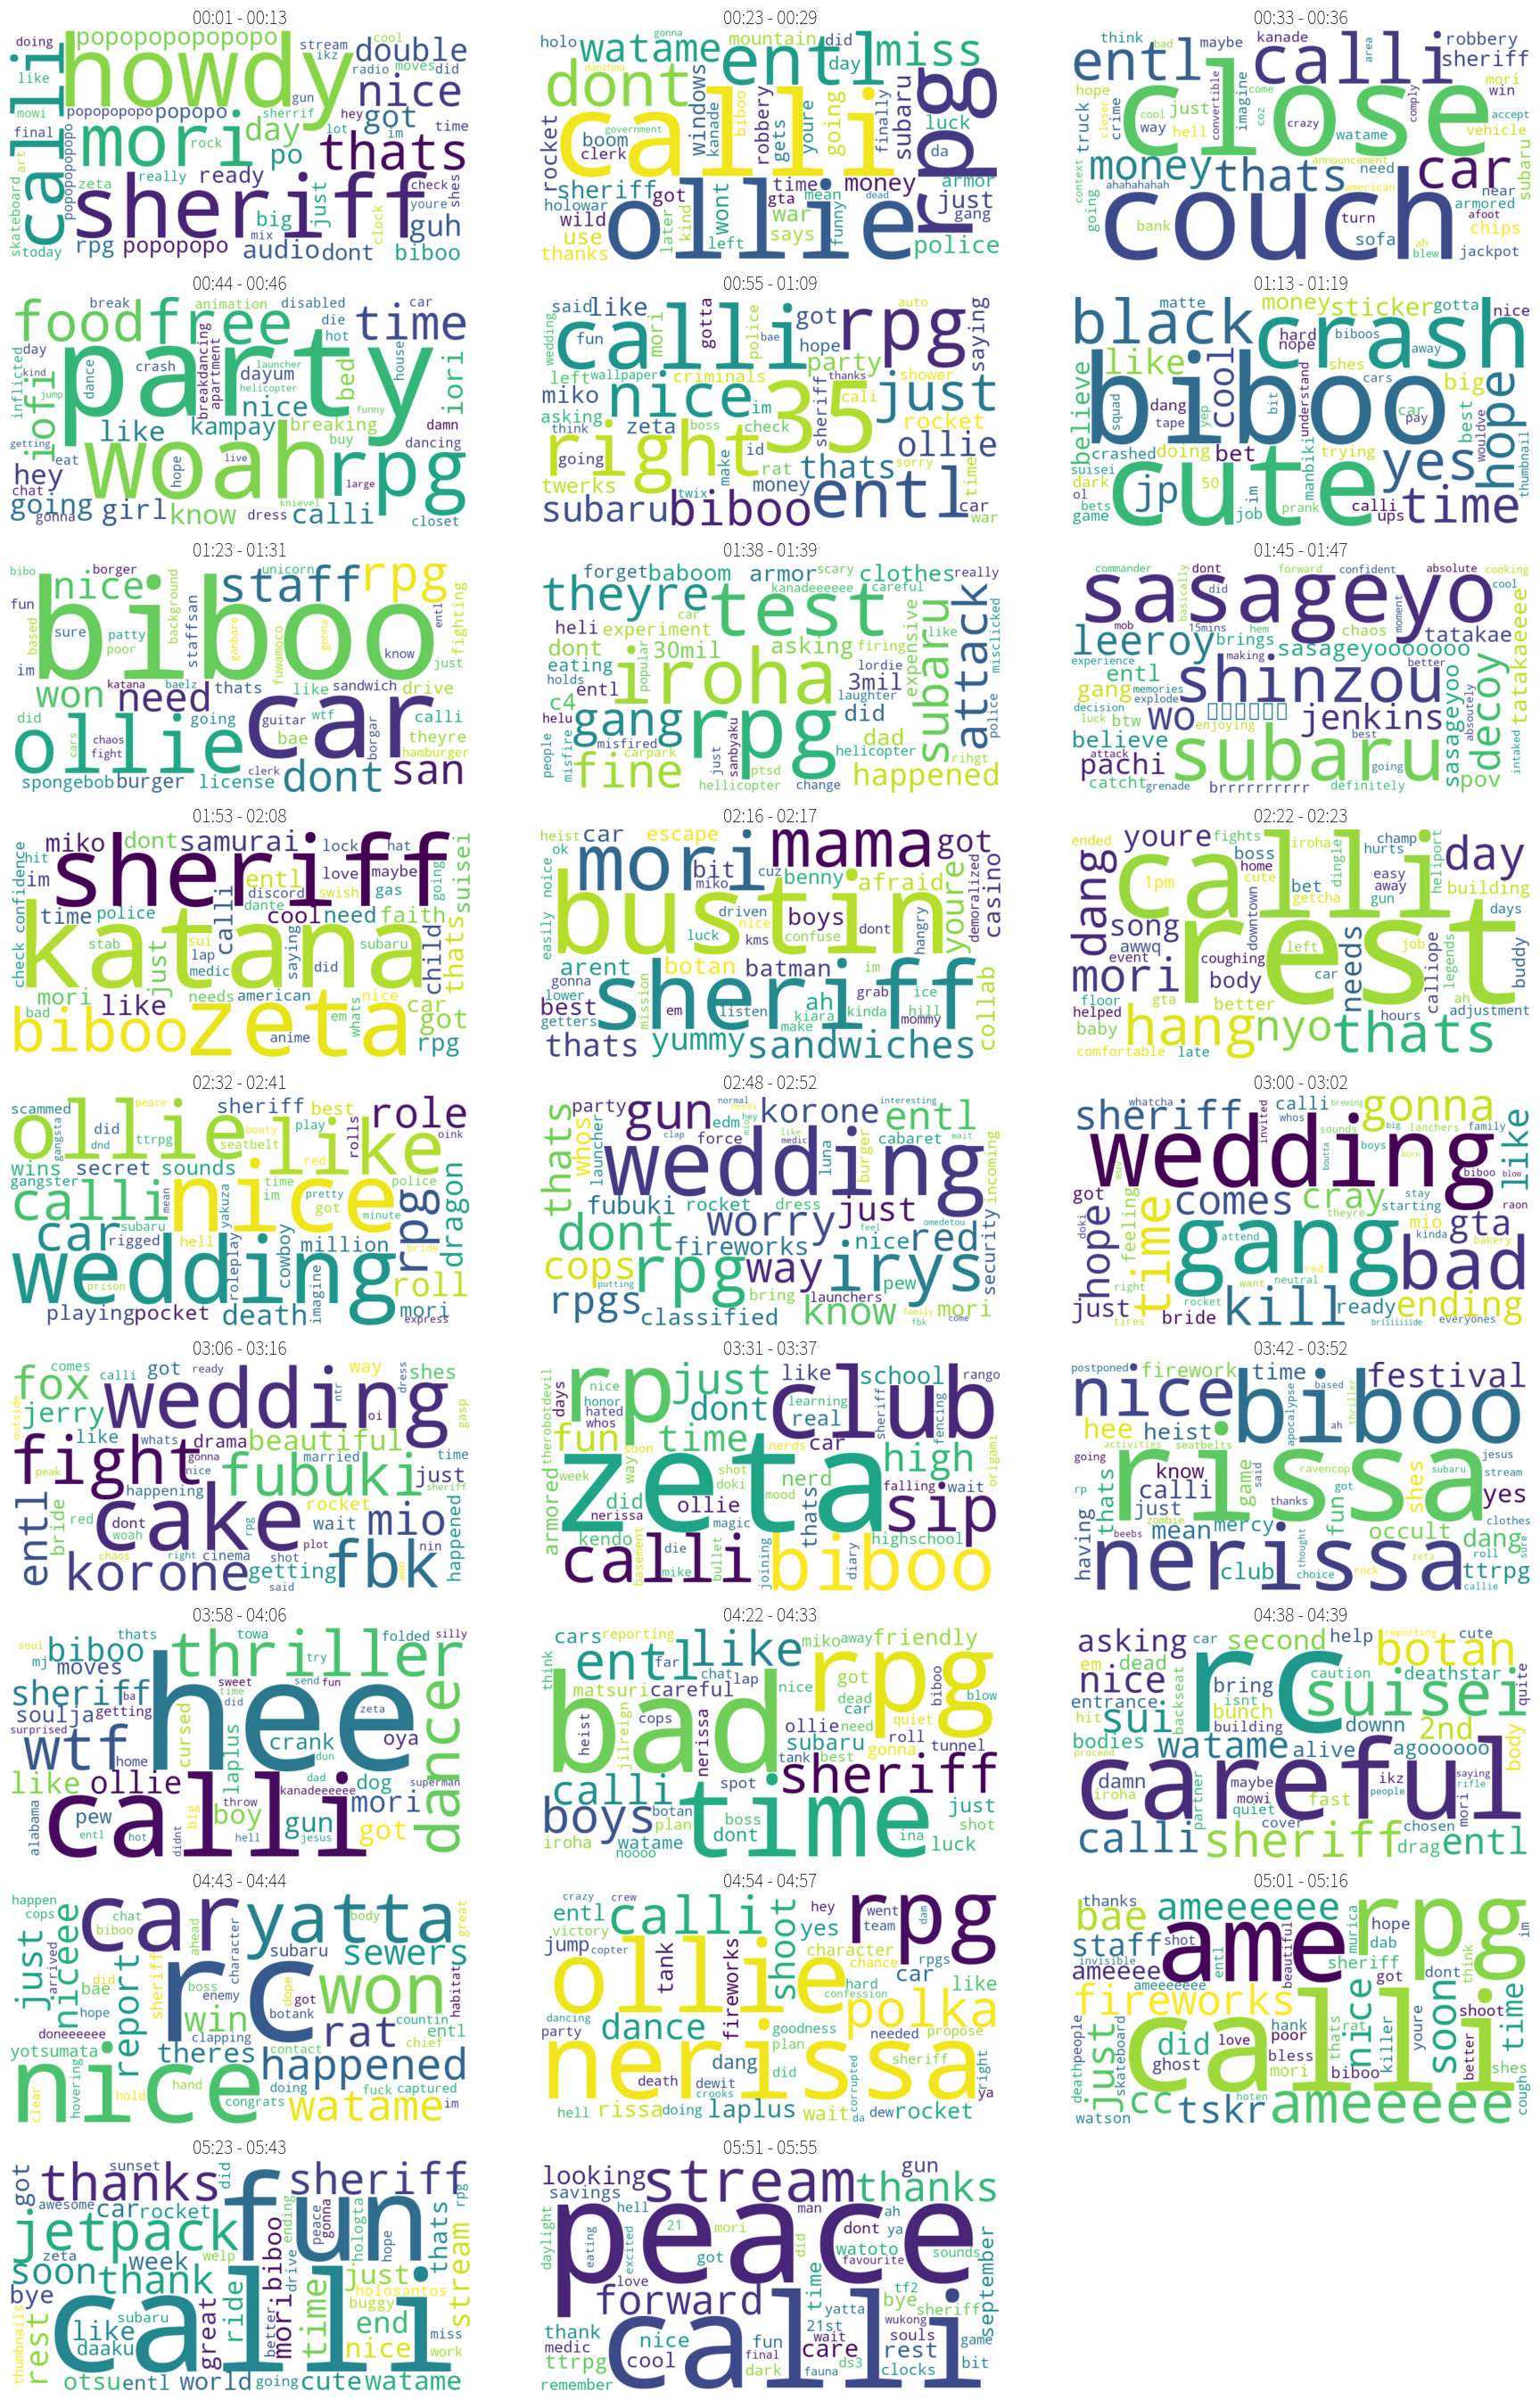

In [21]:
num_intervals = len(chat.activity_ranges)
cols = 3
rows = math.ceil(num_intervals / cols)

fig, axes = plt.subplots(rows, cols, figsize=(18, 3 * rows))

index = -1
for i, time_range in enumerate(chat.activity_ranges):
    try:
        index += 1
        start = time_range[0] * 60
        end = time_range[1] * 60
        start_label = minutes_to_hhmm(time_range[0])
        end_label = minutes_to_hhmm(time_range[1])

        df_filtered = df[(df['time_in_seconds'] >= start) & (df['time_in_seconds'] <= end) & (df['cleaned_message'].str.len() > 0)]

        word_freq = get_word_freq(df_filtered['cleaned_message'])
        word_path = os.path.join(env_.data_path, f'{start_label}_{end_label}'.replace(':', '-'))
        wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50, min_word_length=3).generate_from_frequencies(word_freq)

        df_filtered[['time_in_seconds', 'message']].to_csv(f'{word_path}_chat.csv', encoding='utf8', index=False)
        word_freq.to_csv(f'{word_path}_wfreq.csv', encoding='utf8', header=False)

        ax = axes[index // cols][index % cols] if rows > 1 else axes[index % cols]

        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis("off")

        ax.set_title(f'{start_label} - {end_label}', fontsize=14)
    except Exception as e:
        index -= 1
        continue

for j in range(index + 1, rows * cols):
    fig.delaxes(axes[j // cols][j % cols] if rows > 1 else axes[j % cols])

plt.tight_layout()
plt.savefig(env_.chat_wordcloud_path)
plt.show()

In [22]:
font_name = os.getenv('DEFAULT_FONT_NAME')
font_path = f"{os.getenv('DEFAULT_FONT_PATH')}/{font_name}/{os.getenv('DEFAULT_FONT_FILENAME')}"
pdfmetrics.registerFont(TTFont(font_name, font_path, 'utf8'))

c = canvas.Canvas(os.path.join(env_.data_path, 'report.pdf'), pagesize=A4)

width, height = A4
cursor = height
margin = 8
available_width = width - 2 * margin

c.setFont(font_name, 16)

cursor = height - 32

text_width = c.stringWidth(env_.video_title)
x_position = (available_width - text_width) / 2  # 計算置中位置

c.drawString(x_position, cursor, env_.video_title)

c.setFont(font_name, 12)
cursor = cursor - 17
text_width = c.stringWidth(env_.video_liver)
x_position = (available_width - text_width)
c.drawString(x_position, cursor, env_.video_liver)

# cursor = cursor - 10
# cursor = draw_markdown_to_pdf(c, summary, cursor, margin, width, height, font_name)

image = ImageReader(env_.chat_timeline_path)
img_width, img_height = image.getSize()

# 計算圖片縮放比例，保持等比例縮放
scale_factor = available_width / img_width
scaled_width = available_width
scaled_height = img_height * scale_factor

# 如果圖片的高度超過頁面，則根據頁面的高度進行縮放
if scaled_height > height:
    scale_factor = height / img_height
    scaled_height = height
    scaled_width = img_width * scale_factor

# 計算圖片位置（居中顯示圖片）
x_position = margin  # 左右保持 8px 的空格
cursor = y_position = cursor - scaled_height - 10

# 插入圖片
c.drawImage(image, x_position, y_position, width=scaled_width, height=scaled_height)

image = ImageReader(env_.chat_wordcloud_path)
img_width, img_height = image.getSize()

# 計算圖片縮放比例，保持等比例縮放
scale_factor = available_width / img_width
scaled_width = available_width
scaled_height = img_height * scale_factor

# 如果圖片的高度超過頁面，則根據頁面的高度進行縮放
if scaled_height > height:
    scale_factor = height / img_height
    scaled_height = height
    scaled_width = img_width * scale_factor

# 計算圖片位置（居中顯示圖片）
x_position = margin  # 左右保持 8px 的空格
cursor = y_position = cursor - scaled_height - 10

# 插入圖片
c.drawImage(image, x_position, y_position, width=scaled_width, height=scaled_height)

c.save()
